In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from preprocess_data import split_dataset_by_class

split_dataset_by_class(
    source_dir='data',
    output_base_dir='maize_leaf_split_dataset',
    split_ratios=(0.9, 0.05, 0.05)
)

Copying Test images for 'Healthy': 100%|██████████| 59/59 [00:00<00:00, 98.17it/s] 


 Dataset split completed!


In [ ]:
from preprocess_data import get_class_distribution
train_dir = 'maize_leaf_split_dataset/Train'
valid_dir = 'maize_leaf_split_dataset/Valid'
test_dir = 'maize_leaf_split_dataset/Test'


print(f"Class distribution in the training set: {get_class_distribution(train_dir)}")
print(f"Class distribution in the validation set: {get_class_distribution(valid_dir)}")
print(f"Class distribution in the test set: {get_class_distribution(test_dir)}")

Class distribution in the training set: {'Blight': 1031, 'Common_Rust': 1175, 'Gray_Leaf_Spot': 516, 'Healthy': 1045}
Class distribution in the validation set: {'Blight': 57, 'Common_Rust': 65, 'Gray_Leaf_Spot': 28, 'Healthy': 58}
Class distribution in the test set: {'Blight': 58, 'Common_Rust': 66, 'Gray_Leaf_Spot': 30, 'Healthy': 59}


Dropped 516 images from class: 'Blight'. Retained 515 images.
Dropped 660 images from class: 'Common_Rust'. Retained 515 images.
Dropped 1 images from class: 'Gray_Leaf_Spot'. Retained 515 images.
Dropped 530 images from class: 'Healthy'. Retained 515 images.

Class: Blight


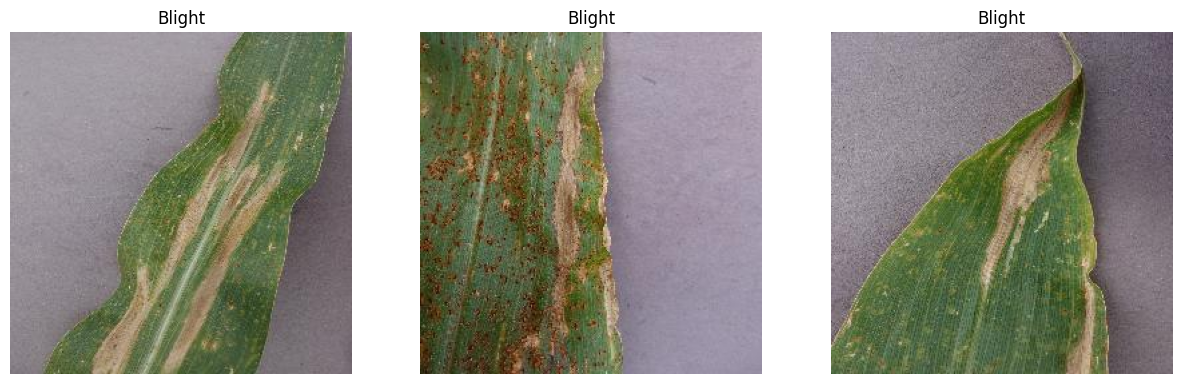


Class: Common_Rust


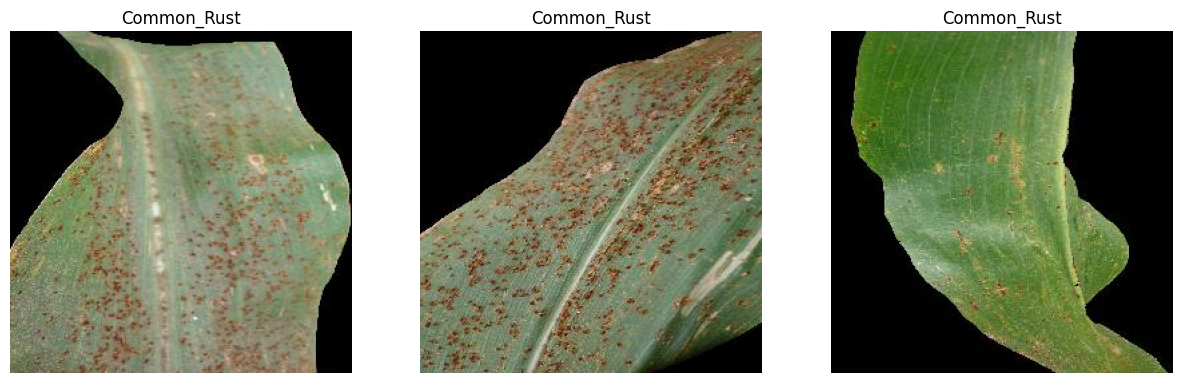


Class: Gray_Leaf_Spot


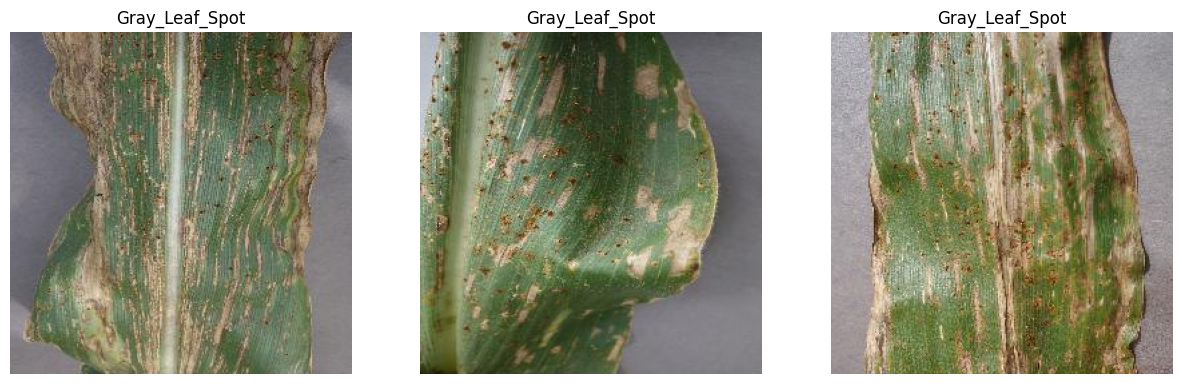


Class: Healthy


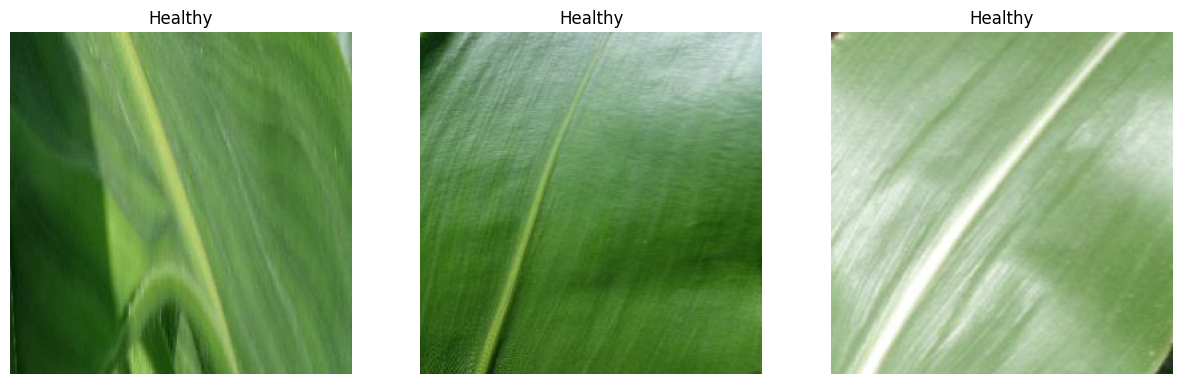

In [ ]:
from visualize_downsample import visualize_samples, plot_class_distribution, drop_images

visualize_samples(train_dir, num_samples=3)

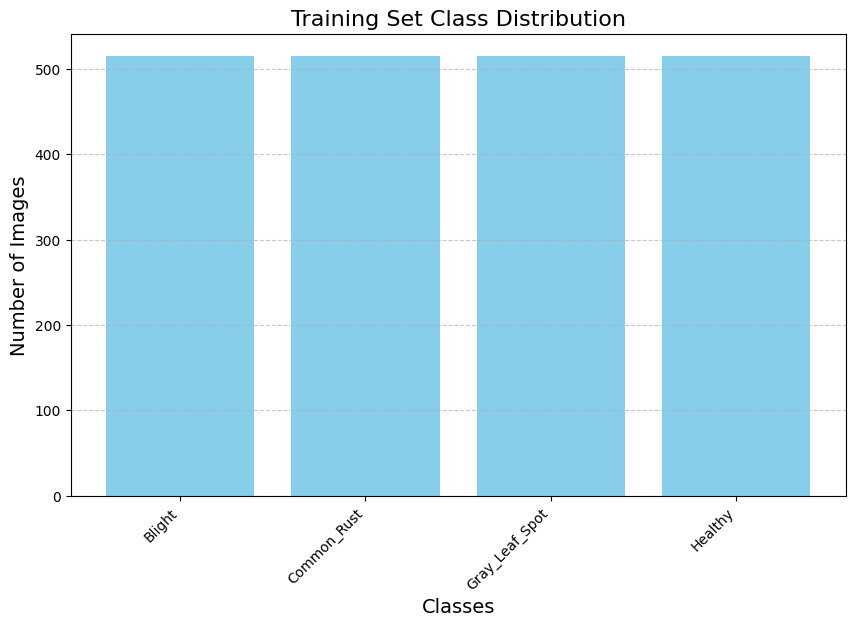

In [ ]:
plot_class_distribution(get_class_distribution(train_dir), title='Training Set Class Distribution')

In [ ]:
from load_data import create_dataloaders

train_dir = 'maize_leaf_split_dataset/Train'
valid_dir = 'maize_leaf_split_dataset/Valid'
test_dir = 'maize_leaf_split_dataset/Test'

train_loader, valid_loader, test_loader = create_dataloaders(
    train_dir=train_dir,
    valid_dir=valid_dir,
    test_dir=test_dir,
    batch_size=32,
)

In [ ]:
from model_builder import load_model
model = load_model(num_labels=4)

c:\Users\ACER NITRO 5\Desktop\Capstone Project\capstone_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import wandb

wandb.init(
    project="maize-leaf-disease-identification-model",
    name="using-vit-pretrained",
    config={
        "epochs": 40,
        "batch_size": 32,
        "optimizer": "Adam",
        "architecture": "ViT-base-patch16-224"
        }
    )

wandb: Currently logged in as: ufee (ufee-gsu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from train_validate_save_model import train_and_validate
from torch import nn
from torch import optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_and_validate(model=model, trainloader=train_loader, validloader=valid_loader, criterion=criterion, optimizer=optimizer, device=device, epochs=40)


Epoch 1/40 | Train Loss: 1.2095 | Train Acc: 48.45% | Val Loss: 0.9443 | Val Acc: 66.67%
Epoch 2/40 | Train Loss: 0.8501 | Train Acc: 72.86% | Val Loss: 0.6785 | Val Acc: 75.59%
Epoch 3/40 | Train Loss: 0.6769 | Train Acc: 78.74% | Val Loss: 0.5552 | Val Acc: 77.46%
Epoch 4/40 | Train Loss: 0.5988 | Train Acc: 81.26% | Val Loss: 0.4806 | Val Acc: 78.87%
Epoch 5/40 | Train Loss: 0.5357 | Train Acc: 83.20% | Val Loss: 0.4361 | Val Acc: 81.22%
Epoch 6/40 | Train Loss: 0.4889 | Train Acc: 84.51% | Val Loss: 0.4093 | Val Acc: 81.22%
Epoch 7/40 | Train Loss: 0.4611 | Train Acc: 85.19% | Val Loss: 0.3655 | Val Acc: 84.51%
Epoch 8/40 | Train Loss: 0.4339 | Train Acc: 86.17% | Val Loss: 0.3441 | Val Acc: 84.98%
Epoch 9/40 | Train Loss: 0.4123 | Train Acc: 87.43% | Val Loss: 0.3370 | Val Acc: 85.45%
Epoch 10/40 | Train Loss: 0.3884 | Train Acc: 87.77% | Val Loss: 0.3253 | Val Acc: 85.92%
Epoch 11/40 | Train Loss: 0.3722 | Train Acc: 87.82% | Val Loss: 0.3122 | Val Acc: 85.92%
Epoch 12/40 | Train

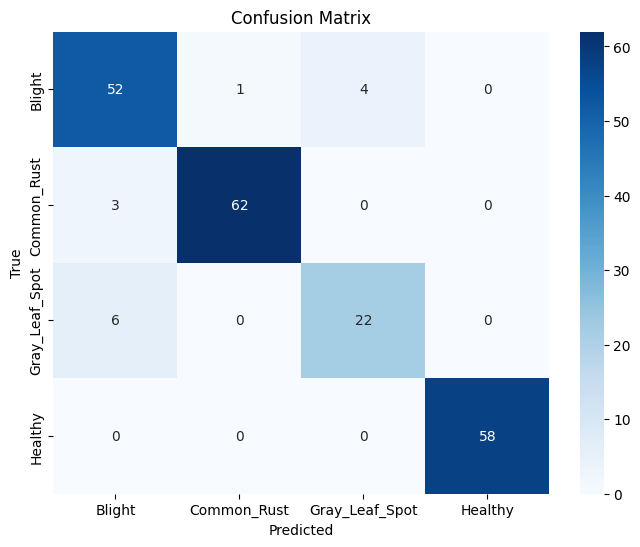


Classification Report:
                precision    recall  f1-score   support

        Blight       0.85      0.91      0.88        57
   Common_Rust       0.98      0.95      0.97        65
Gray_Leaf_Spot       0.85      0.79      0.81        28
       Healthy       1.00      1.00      1.00        58

      accuracy                           0.93       208
     macro avg       0.92      0.91      0.92       208
  weighted avg       0.93      0.93      0.93       208

ROC-AUC Score (OvR): 0.9855


In [ ]:
from torchvision import datasets, transforms
from evaluate_model import evaluate_model

test_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_datasets = datasets.ImageFolder(test_dir, transform = test_transforms)


evaluate_model(model, testloader=test_loader, test_datasets=test_datasets, device=device)

In [ ]:
from train_validate_save_model import save_model

save_model(model, 'saved model/maize_leaf_disease_model.pth')

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Model saved to saved model/maize_leaf_disease_model.pth
/n/nTraining completed successfully!


In [2]:
from transformers import ViTForImageClassification

num_labels = 4  # Set the number of labels for classification

model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

model.load_state_dict(torch.load("saved model/maize_leaf_disease_model.pth", map_location='cpu'))

<All keys matched successfully>

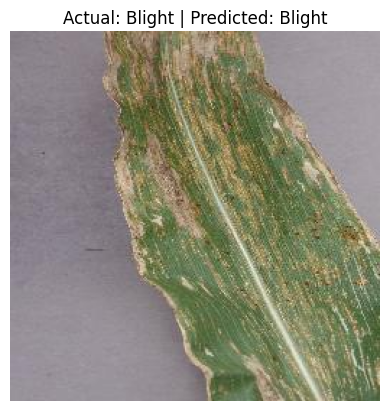

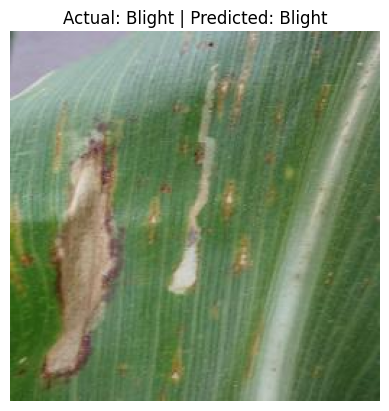

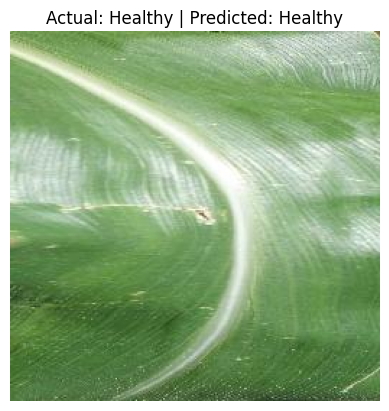

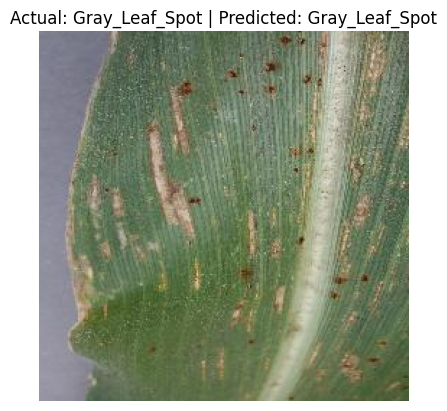

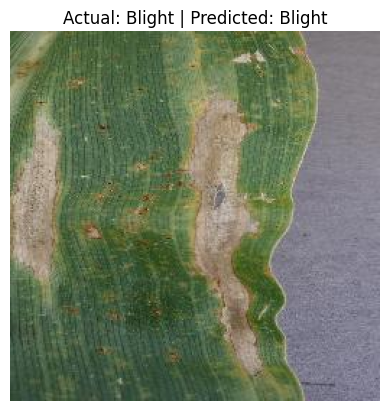

In [ ]:
from predictions import predict_and_plot_random_images

from torchvision import transforms

test_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_dir = 'maize_leaf_split_dataset/Test'
class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

predict_and_plot_random_images(
    model= model,
    test_dir= test_dir,
    class_names= class_names,
    transform= test_transforms,
    device= torch.device("cpu"),
    num_images= 5
)

In [1]:
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import torch

num_labels = 4  # Set the number of labels for classification

model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to 

In [ ]:

model.load_state_dict(torch.load("saved model/maize_leaf_disease_model.pth", map_location='cpu'))

<All keys matched successfully>

In [4]:
labels = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

model.eval()

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [5]:
from typing import Tuple, Dict
from timeit import default_timer as timer


def predict(img) -> Tuple[Dict[str, float], float]:
    start_time = timer()

    try:
        # Preprocess the image using your processor
        inputs = processor(images=img, return_tensors="pt")

        # Model prediction
        with torch.inference_mode():
            outputs = model(**inputs)
            logits = outputs.logits
            pred_probs = torch.softmax(logits, dim=1)

        # Return class probabilities as decimals (0.0 to 1.0)
        pred_dict = {
            labels[i]: round(float(pred_probs[0][i]), 4) for i in range(len(labels))
        }

        pred_time = round(timer() - start_time, 5)

        return pred_dict, pred_time

    except Exception as e:
        print(f"[ERROR] {e}")
        return {"Error": 0.0}, 0.0

In [6]:
import gradio as gr

title = "Maize Leaf Disease Detector 🌽"
description = "Upload a maize leaf image to detect disease. Output shows prediction confidence (%) for each class."
article = "Capstone Project: Arewa Data Science Fellowship"

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=4, label="Predictions (%)"),
        gr.Number(label="Prediction time (s)")
    ],
    title=title,
    description=description,
    article=article
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7224cda64075dc013d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
